# **Synthetic Transaction Fraud Detection**

Srinivas Natarajan - 18BCE0048 <br/>
Rahul - 18BCE0018 <br/>
Vrinda Chopra - 18BCE0785


---

<br/>

# **A. Libraries**

In [40]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time

In [13]:
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from statsmodels.tools import categorical

In [27]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from scipy.stats import skew, boxcox

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, precision_score,accuracy_score,f1_score, precision_recall_curve,auc
from sklearn.metrics import average_precision_score, roc_auc_score,roc_curve,recall_score,classification_report 

In [5]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from catboost import CatBoostClassifier

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

---

<br />

# **B Reading Data**

In [7]:
df = pd.read_csv('D:\VIT\SEM-6\F2 - Machine Learning\Project\Synthetic_transactions.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Number of Records: 6,362,620 (6.3 million transactions)

In [8]:
print("Number of records: {:,}".format(len(df)))

Number of records: 6,362,620


In [9]:
df.isnull().values.any()

False

In [19]:
tmp = df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
tmp = tmp.reset_index(drop=True)
a = np.array(tmp['type'])
b = categorical(a, drop=True)
tmp['type_num'] = b.argmax(1)

D:\Anaconda\envs\ML\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
D:\Anaconda\envs\ML\lib\site-packages\statsmodels\tools\tools.py:162: FutureWarning: categorical is deprecated. Use pandas Categorical to represent categorical data and can get_dummies to construct dummy arrays. It will be removed after release 0.13.
  FutureWarning


---

<br />

# **C. Exploratory Data Analysis**

### **i) Imbalance of the Dataset**

In [14]:
print("The percentage of fradulent transactions is: ", round((len(df[df["isFraud"]==1])/len(df))*100,3),"%"  )

The percentage of fradulent transactions is:  0.129 %


0    6354407
1       8213
Name: isFraud, dtype: int64


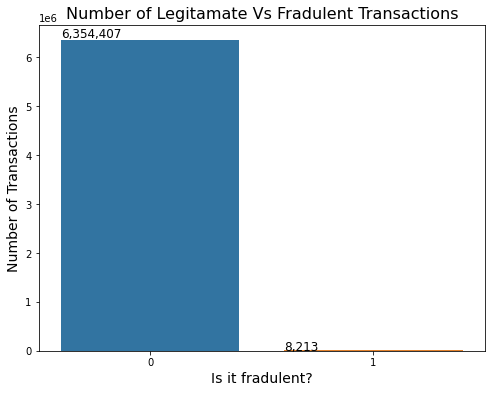

In [15]:
# count number of fraud and not fraud data
print(df.isFraud.value_counts())
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='isFraud')
ax.set_title("Number of Legitamate Vs Fradulent Transactions",fontsize=16)
ax.set_xlabel("Is it fradulent?",fontsize=14)
ax.set_ylabel('Number of Transactions',fontsize=14)

for p in ax.patches:
    ax.annotate( str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01), fontsize=12 )

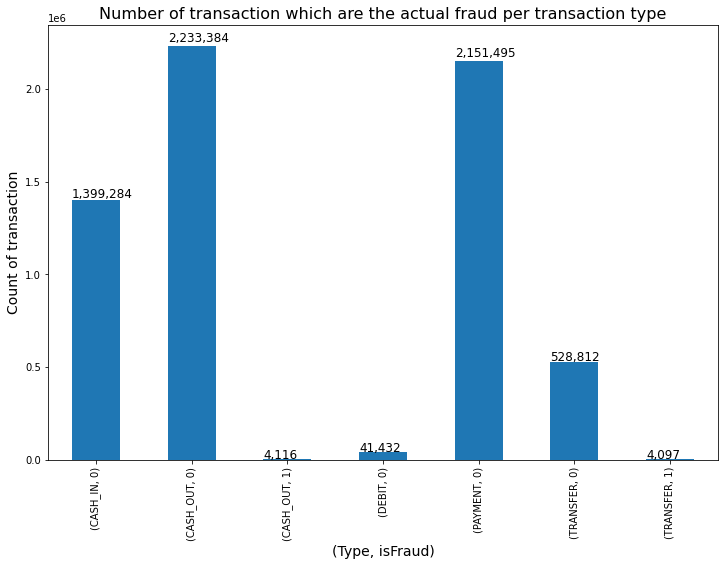

In [16]:
plt.figure(figsize=(12,8))
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("Number of transaction which are the actual fraud per transaction type",fontsize=16)
ax.set_xlabel("(Type, isFraud)",fontsize=14)
ax.set_ylabel("Count of transaction",fontsize=14)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01), fontsize=12)

---

<br />
<br />

### **ii) Transactions to select**

In [17]:
#Groupby type   
df.groupby('type')['isFraud','isFlaggedFraud'].sum()

C:\Users\nsrin\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


In [18]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [23]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 42
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0           
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [ ]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [ ]:
Y.head()

2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

In [ ]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [ ]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [ ]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


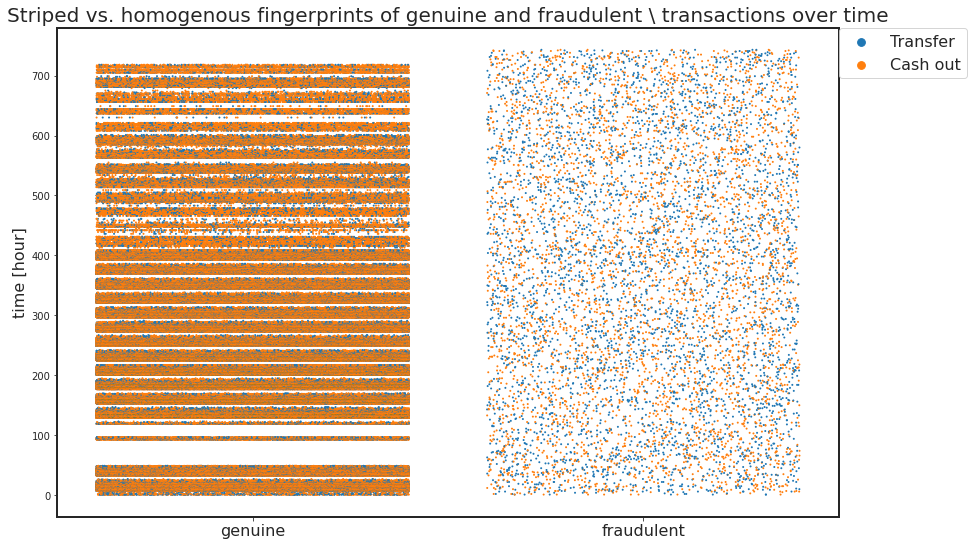

In [ ]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \ transactions over time', size = 20);

The plot above shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


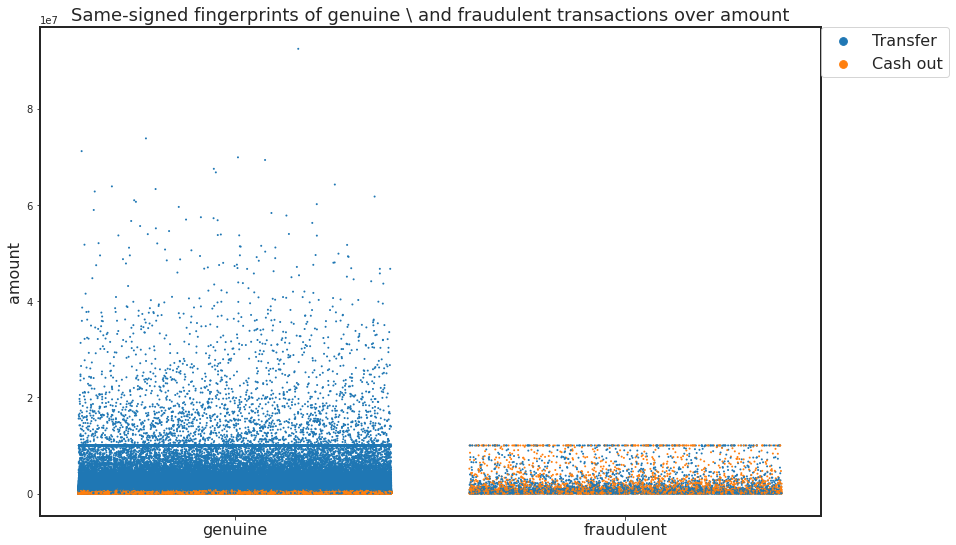

In [ ]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \ and fraudulent transactions over amount', size = 18);

---

<br />
<br/>

### **iii) Atrributes to select for model**

<AxesSubplot:>

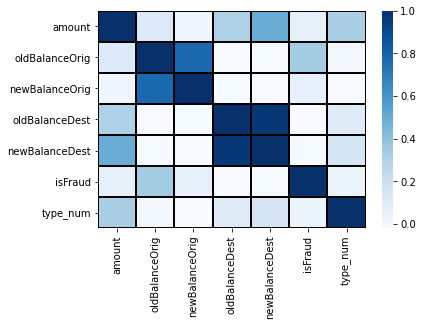

In [21]:
sns.heatmap(tmp.corr(), linecolor='black', linewidth=1, cmap='Blues')

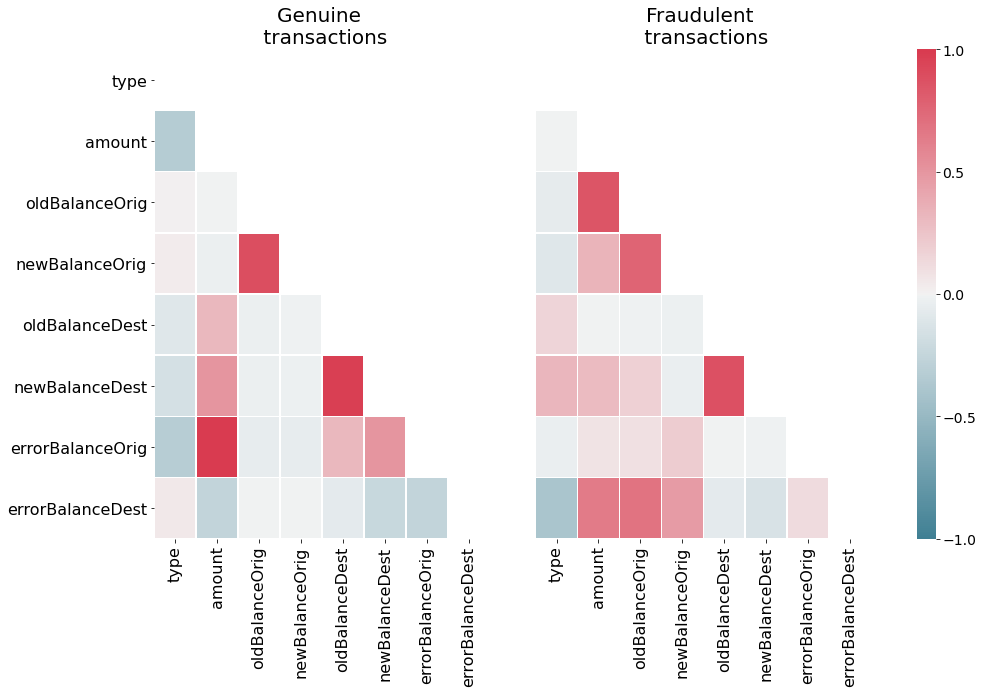

In [ ]:
Xfraud = X.loc[Y == 1]            # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

#Matrix Size
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize = (14, 9))

#Genuine Transactions
cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

#Fradulent Transactions
correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

In [ ]:
df_fraud = df.loc[(df.isFraud == 1)]
df_leg = df.loc[(df.isFraud == 1)]
corr_fraud = df_fraud.loc[:, df_fraud.columns != 'step'].corr(method="spearman")

In [ ]:
def top_corr(corr,target, n):
  abs_corr = (corr.abs().unstack())[target].to_dict()
  abs_corr.pop(target)
  sorted_corr = dict( sorted(abs_corr.items(), key=lambda item: item[1], reverse=True))
  if n>len(sorted_corr): 
    n = sorted_corr
  sorted_corr = [item for item in sorted_corr.keys()][:n]
  return sorted_corr

In [ ]:
temp = top_corr(corr_fraud,"isFraud",5)
print("The top %d factors which affect the target are: "%(len(temp)))
for item in temp:
  print("-> ",item) 

The top 5 factors which affect the target are: 
->  amount
->  oldBalanceOrig
->  newBalanceOrig
->  oldBalanceDest
->  newBalanceDest


---

<br/>
<br />

### **iv) Skewness of the Data and Attributes**

**a) Transaction Amount**

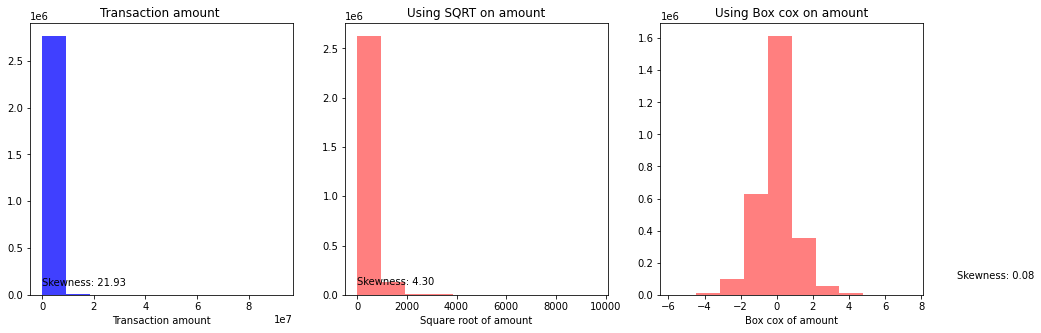

In [29]:
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['amount'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Transaction amount") 
plt.title("Transaction amount ") 
plt.text(10,100000,"Skewness: {0:.2f}".format(skew(tmp['amount'])))

figure.add_subplot(132)
plt.hist(np.sqrt(tmp['amount']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of amount")
plt.title("Using SQRT on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['amount']))))

figure.add_subplot(133)
plt.hist(tmp['amount_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of amount")
plt.title("Using Box cox on amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(tmp['amount_boxcox'])))

plt.show()

<br/>

**b. Old Balance of Account**

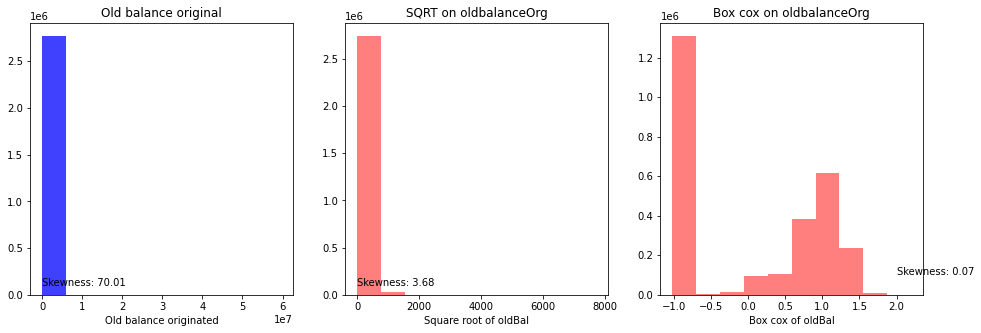

In [34]:
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldBalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldBalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance originated") 
plt.title("Old balance original") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldBalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldBalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBal")
plt.title("SQRT on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldBalanceOrig']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox on oldbalanceOrg")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceOrg_boxcox'])))

plt.show()

<br />

**c. New Balance of account**

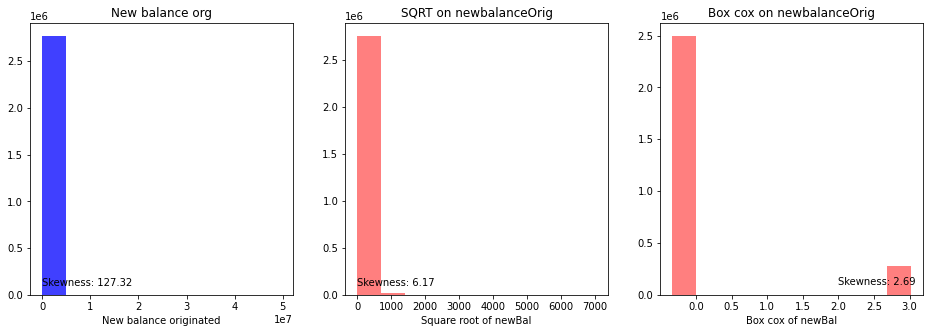

In [36]:
tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newBalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newBalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance originated") 
plt.title("New balance org") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newBalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newBalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newBalanceOrig']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceOrg_boxcox'])))

plt.show()

<br />

**d. Old Balance of destination**

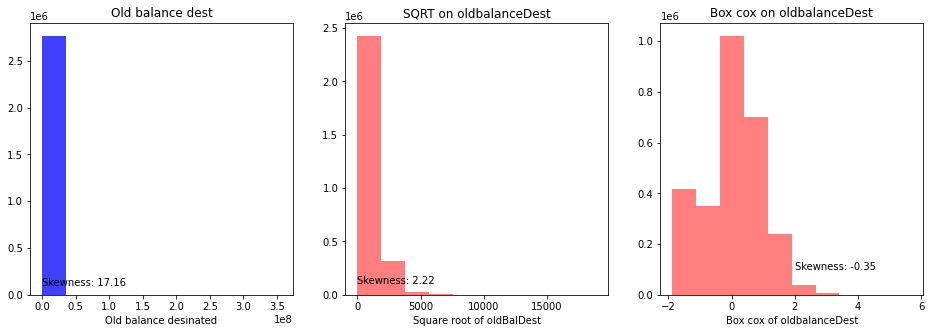

In [38]:
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldBalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['oldBalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance desinated") 
plt.title("Old balance dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['oldBalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['oldBalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBalDest")
plt.title("SQRT on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['oldBalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['oldbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldbalanceDest")
plt.title("Box cox on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['oldbalanceDest_boxcox'])))

plt.show()

<br />

**e. New Balance of Destination**

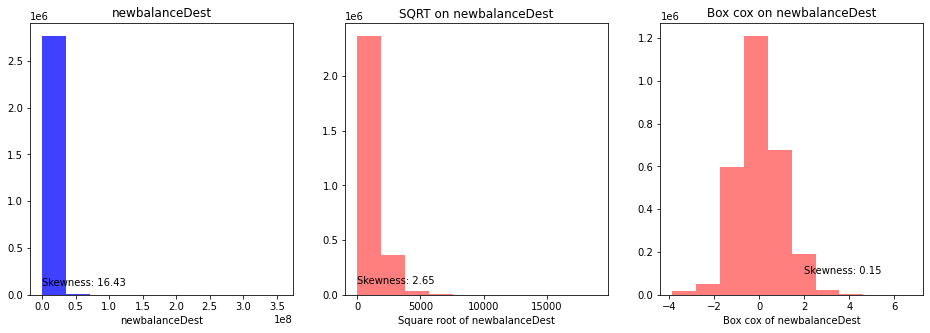

In [39]:
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newBalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(tmp['newBalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("newbalanceDest") 
plt.title("newbalanceDest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(tmp['newBalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(tmp['newBalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newbalanceDest")
plt.title("SQRT on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(tmp['newBalanceDest']))))

figure.add_subplot(133)
plt.hist(tmp['newbalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newbalanceDest")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(tmp['newbalanceDest_boxcox'])))

plt.show()

---

<br/>
<br/>

# **D. Models**

In [41]:
data_counts = Counter(Y)
print("Legitimate: {:,}".format(data_counts[0]))
print("Fraudulent: {:,}".format(data_counts[1]))

Legitimate: 2,762,196
Fraudulent: 8,213


<br/>

## **1. Logistic Regression**

### **A. Under Sampling Data**

In [42]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X, Y)
X_under, Y_under = rus.fit_resample(X, Y)

In [43]:
data_under = Counter(Y_under)
print("Legitimate: {:,}".format(data_under[0]))
print("Fraudulent: {:,}".format(data_under[1]))

Legitimate: 8,213
Fraudulent: 8,213


In [44]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under,Y_under,test_size = 0.2,random_state = 0)
print("Number transactions train dataset: ", format(len(X_train_under),',d'))
print("Number transactions test dataset: ", format(len(X_test_under),',d'))
print("Total number of transactions: ", format(len(X_train_under)+len(X_test_under),',d'))

Number transactions train dataset:  13,140
Number transactions test dataset:  3,286
Total number of transactions:  16,426


In [45]:
lr_under = LogisticRegression()

In [46]:
start = time.time()
lr_under.fit(X_train_under, y_train_under)
y_pred_under = lr_under.predict(X_test_under)
end = time.time()
time_lr = end-start

In [47]:
def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    auprc = round((average_precision_score(y_test, y_prob[:, 1])),3)
    f1 = round(f1_score(y_test,y_pred),3)
    acc = round(accuracy_score(y_test,y_pred),3)
    recall = round(recall_score(y_test, y_pred, average='micro'),3)

    print('AUPRC :', auprc)
    print('F1 - score :', f1)
    print("Accuracy Score: ", acc)
    print("Recall Score: ", recall)
    print("\nClassification Report:")
    print(classification_report(y_test,y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, annot_kws={"size": 16},
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            linewidth=1,
            linecolor='black',
            cmap ="Blues"
            )
    plt.title("Confusion matrix",fontsize=16)
    return {'auprc': auprc, 'f1':f1, 'accuracy':acc, 'recall':recall}


Test Results: 

AUPRC : 0.976
F1 - score : 0.925
Accuracy Score:  0.921
Recall Score:  0.921

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.92      1630
           1       0.89      0.97      0.92      1656

    accuracy                           0.92      3286
   macro avg       0.92      0.92      0.92      3286
weighted avg       0.92      0.92      0.92      3286



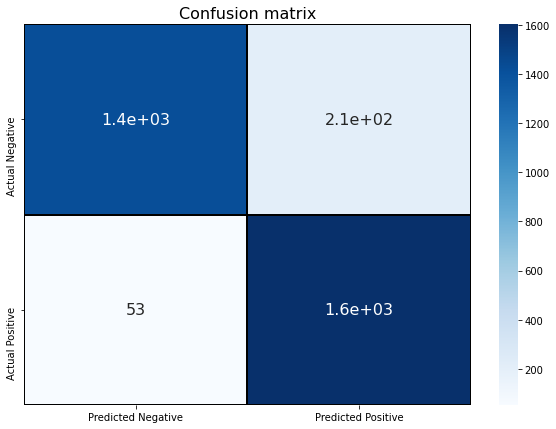

In [49]:
print ('\nTest Results: \n')
lr_under_results = model_result(lr_under,X_test_under,y_test_under)

### **B. Oversampling (SMOTE)**

In [50]:
from imblearn.over_sampling import SMOTE

In [51]:
oversample = SMOTE()
X_over, Y_over = oversample.fit_resample(X, Y)

In [52]:
data_over = Counter(Y_over)
print("Legitimate: {:,}".format(data_over[0]))
print("Fraudulent: {:,}".format(data_over[1]))

Legitimate: 2,762,196
Fraudulent: 2,762,196


In [53]:
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over,Y_over, test_size = 0.2, random_state = 0)
print("Number transactions train dataset: ", format(len(X_train_over),',d'))
print("Number transactions test dataset: ", format(len(X_test_over),',d'))
print("Total number of transactions: ", format(len(X_train_over)+len(X_test_over),',d'))

Number transactions train dataset:  4,419,513
Number transactions test dataset:  1,104,879
Total number of transactions:  5,524,392


In [54]:
lr_over = LogisticRegression()

In [55]:
start = time.time()
lr_over.fit(X_train_over, y_train_over)
y_pred_over = lr_over.predict(X_test_over)
end = time.time()
time_lr_smote = end-start
print(time_lr_smote)

26.258177757263184



Test Results: 

AUPRC : 0.978
F1 - score : 0.933
Accuracy Score:  0.93
Recall Score:  0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    553120
           1       0.90      0.97      0.93    551759

    accuracy                           0.93   1104879
   macro avg       0.93      0.93      0.93   1104879
weighted avg       0.93      0.93      0.93   1104879



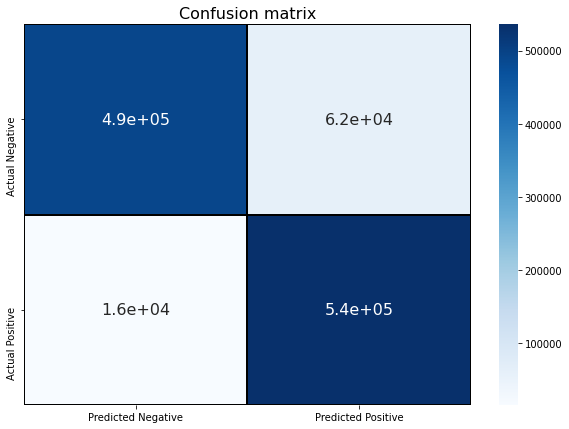

In [56]:
print ('\nTest Results: \n')
lr_over_results = model_result(lr_over,X_test_over,y_test_over)

<br/>
<br/>

## **2. Random Forest**

In [58]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, Y, test_size = 0.3,random_state=42, shuffle=False)

In [59]:
rf=RandomForestClassifier()

In [60]:
start = time.time()
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)
end = time.time()
time_rf = end-start 
print(round(time_rf,3))

809.478


AUPRC : 0.912
F1 - score : 0.847
Accuracy Score:  0.999
Recall Score:  0.999

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    826543
           1       1.00      0.74      0.85      4580

    accuracy                           1.00    831123
   macro avg       1.00      0.87      0.92    831123
weighted avg       1.00      1.00      1.00    831123



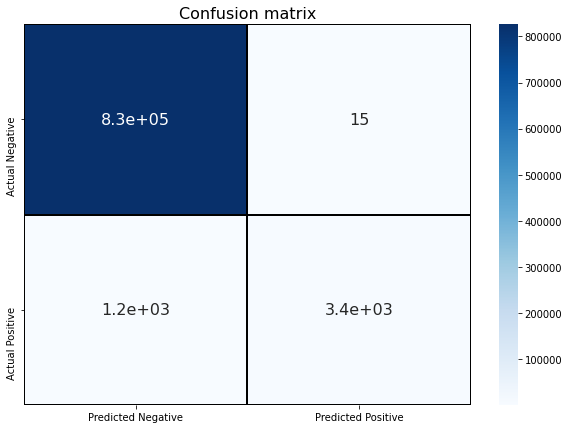

In [61]:
rf_results = model_result(rf,X_test_rf,y_test_rf)

<br/>
<br/>

## **3. XGBoost**

In [62]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, Y, test_size = 0.2, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train_xgb),',d'))
print("Number transactions test dataset: ", format(len(X_test_xgb), ',d'))
print("Total number of transactions: ", format(len(X_train_xgb)+len(X_test_xgb), ',d'))

Number transactions train dataset:  2,216,327
Number transactions test dataset:  554,082
Total number of transactions:  2,770,409


In [63]:
xgb = XGBClassifier()

In [64]:
start = time.time()
xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb.predict(X_test_xgb)
end = time.time()
time_xgb = end-start
print(round(time_xgb,3))

D:\Anaconda\envs\ML\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:13:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
144.449


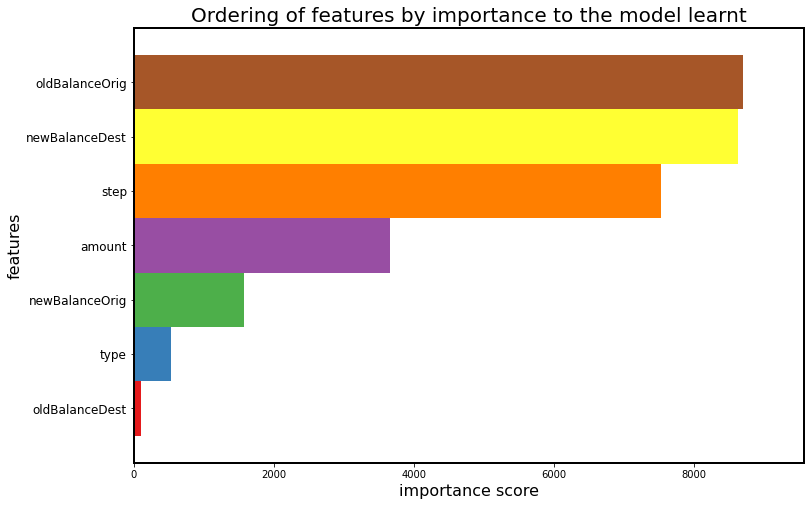

In [65]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(xgb, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

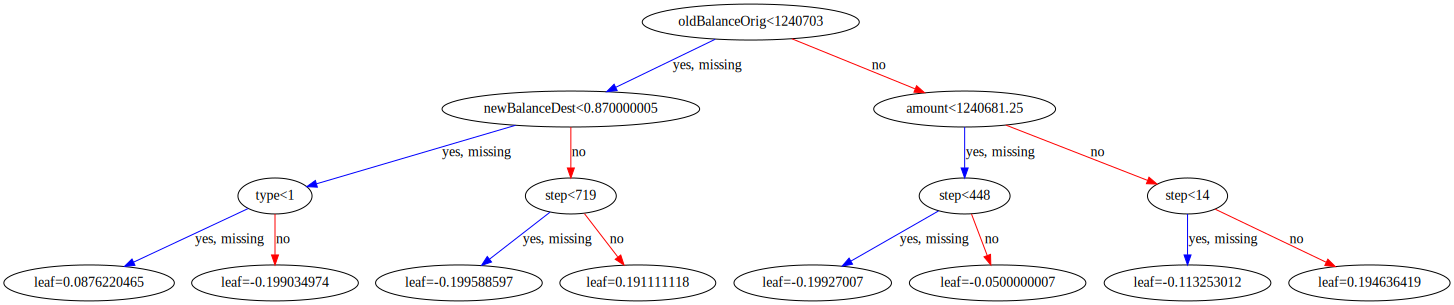

In [ ]:
to_graphviz(xgb)


Test Results: 

AUPRC : 0.982
F1 - score : 0.924
Accuracy Score:  1.0
Recall Score:  1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552446
           1       0.98      0.88      0.92      1636

    accuracy                           1.00    554082
   macro avg       0.99      0.94      0.96    554082
weighted avg       1.00      1.00      1.00    554082



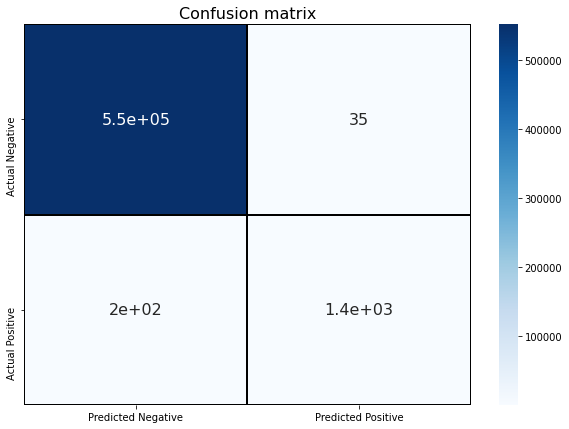

In [67]:
print ('\nTest Results: \n')
xgb_results = model_result(xgb,X_test_xgb,y_test_xgb)

In [68]:
%time
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
trainSizes, trainScores, crossValScores = learning_curve(XGBClassifier(n_jobs = 4, max_depth = 3,scale_pos_weight = weights), 
                                                         X_train_xgb, y_train_xgb, scoring = 'average_precision')

Wall time: 0 ns
D:\Anaconda\envs\ML\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[15:25:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
D:\Anaconda\envs\ML\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass op

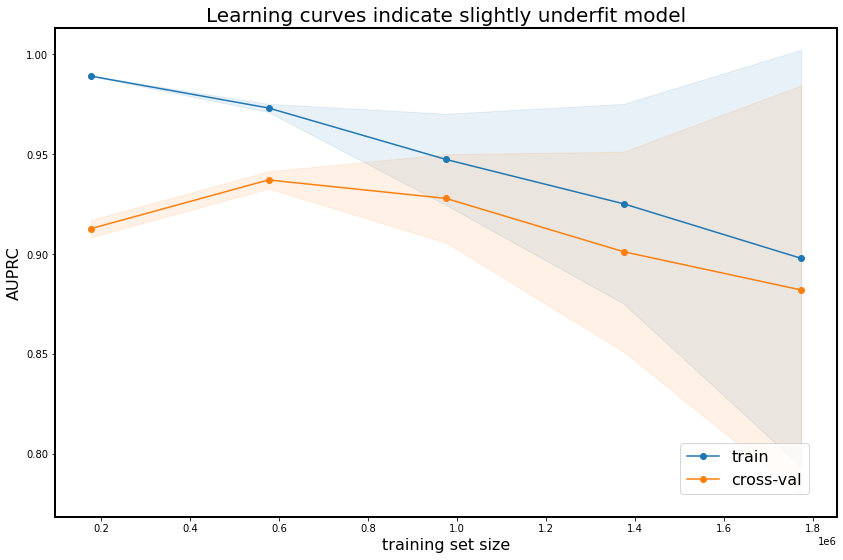

In [69]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd, trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd, crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

<br/>
<br/>

## **4. CATBoost**

In [70]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, Y, test_size = 0.2,random_state=0)

In [84]:
model_cat = CatBoostClassifier(iterations=20, learning_rate=1, depth=4)

In [85]:
start = time.time()
model_cat.fit(X_train_cat,y_train_cat)
y_pred_cat = model_cat.predict(X_test_cat)
end = time.time()
time_cat = end-start 
print(round(time_cat,3))

0:	learn: 0.1321693	total: 189ms	remaining: 3.58s
1:	learn: 0.0471462	total: 341ms	remaining: 3.06s
2:	learn: 0.0198884	total: 489ms	remaining: 2.77s
3:	learn: 0.0103850	total: 633ms	remaining: 2.53s
4:	learn: 0.0088555	total: 781ms	remaining: 2.34s
5:	learn: 0.0058199	total: 927ms	remaining: 2.16s
6:	learn: 0.0052783	total: 1.08s	remaining: 2s
7:	learn: 0.0049713	total: 1.22s	remaining: 1.82s
8:	learn: 0.0047079	total: 1.37s	remaining: 1.68s
9:	learn: 0.0045358	total: 1.52s	remaining: 1.52s
10:	learn: 0.0044621	total: 1.67s	remaining: 1.36s
11:	learn: 0.0043743	total: 1.82s	remaining: 1.21s
12:	learn: 0.0042428	total: 1.97s	remaining: 1.06s
13:	learn: 0.0040678	total: 2.12s	remaining: 906ms
14:	learn: 0.0039091	total: 2.27s	remaining: 756ms
15:	learn: 0.0038127	total: 2.42s	remaining: 605ms
16:	learn: 0.0037715	total: 2.57s	remaining: 454ms
17:	learn: 0.0037349	total: 2.71s	remaining: 301ms
18:	learn: 0.0035938	total: 2.86s	remaining: 151ms
19:	learn: 0.0035193	total: 3.01s	remaining:


Test Results: 

AUPRC : 0.86
F1 - score : 0.843
Accuracy Score:  0.999
Recall Score:  0.999

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552446
           1       0.96      0.75      0.84      1636

    accuracy                           1.00    554082
   macro avg       0.98      0.88      0.92    554082
weighted avg       1.00      1.00      1.00    554082



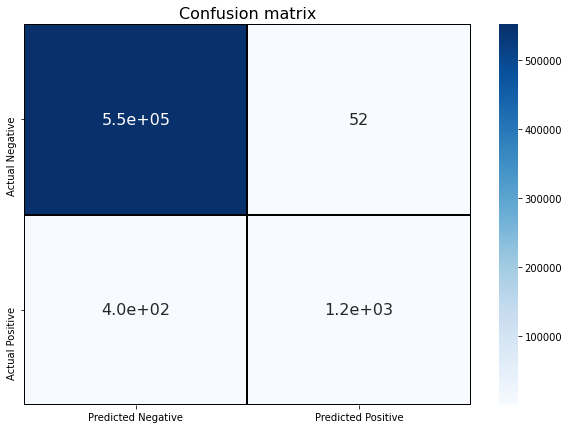

In [86]:
print ('\nTest Results: \n')
cat_results = model_result(model_cat,X_test_cat,y_test_cat)

---

<br />
<br/>

## **E. Results**

In [87]:
label_cols = ["Model", "Accuracy", "Recall", "F-Score", "AUPRC", "Time Taken (Seconds)"]
label_rows = ["Logistic Regression (Under)","Logistic Regression (Over)", "XGBoost","Random Forest", "CatBoost"] #, "CatBoost"
acc = [lr_under_results["accuracy"], lr_over_results["accuracy"], xgb_results["accuracy"], rf_results["accuracy"], cat_results["accuracy"]]
recall = [lr_under_results["recall"], lr_over_results["recall"], xgb_results["recall"], rf_results["recall"], cat_results["recall"]]
auprc = [lr_under_results["auprc"], lr_over_results["auprc"], xgb_results["auprc"], rf_results["auprc"], cat_results["auprc"]]
f_scores = [lr_under_results["f1"], lr_over_results["f1"], xgb_results["f1"], rf_results["f1"], cat_results["f1"]]
times = [round(time_lr,3), round(time_lr_smote,3), round(time_xgb,3), round(time_rf,3), round(time_cat,3)]

In [88]:
results = pd.DataFrame({"Model":label_rows, "Accuracy": acc, "Recall":recall, "F-Scores":f_scores, "AUPRC":auprc, "Time Taken":times})
results.columns = label_cols
results.head(5)

,Model,Accuracy,Recall,F-Score,AUPRC,Time Taken (Seconds)
0,Logistic Regression (Under),0.921,0.921,0.925,0.976,0.232
1,Logistic Regression (Over),0.930,0.930,0.933,0.978,26.258
2,XGBoost,1.000,1.000,0.924,0.982,144.449
3,Random Forest,0.999,0.999,0.847,0.912,809.478
4,CatBoost,0.999,0.999,0.843,0.860,3.813


---

<br />

## StreamLit

In [89]:
import streamlit as st
import plotly.express as px

In [98]:
data_frame = pd.read_csv("D:\VIT\SEM-6\F2 - Machine Learning\Project\Synthetic_transactions.csv")

In [99]:
st.title("Streamlit 101: An in-depth introduction")
st.markdown("Welcome to this in-depth introduction to [...].")
#st.header("Customary quote")
#st.markdown("> I just love to go home, no matter where I am [...]")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)